# Random Forest classification with RAPIDS

In this notebook, we're going to use an algorithm called **Random Forest** to classify pixels in Landsat imagery into different land cover types. Random Forest is commonly used for this type of supervised classification problem, and is what's known as a **decision tree** algorithm. This is exactly what it sounds like - a set of hierarchical rules that are used to determine the output (e.g. "land" or "ocean") based on the input. In this case, the input is the spectral information collected by the Landsat satellites. The algorithm is referred to as **supervised** because we have target variables (the actual land cover classes), and we want the algorithm to be able to predict the target for a given input, even on data it hasn't seen before. To do this, we create a **training** data set, which is a set of inputs (pixel values) for which we already know the target (land cover class). Using the training set, the algorithm can learn how to produce the correct output *y* for a given input *x*.

Actually, Random Forest isn't just one decision tree. It works by creating an **ensemble** of trees, each of which produces an output. Each tree in the "forest" uses a different set of rules, based on different combinations of samples and variables. The final output is decided based on the majority vote across all of the trees. This makes Random Forest both highly flexible and highly unlikely to overfit to the training data.

For a more in-depth explanation of Random Forest, have a look at these articles:

- [Understanding Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)
- [Introduction to Random Forest in Machine Learning](https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/)
- [Random Forest Explained](https://www.youtube.com/watch?v=eM4uJ6XGnSM) 

## Data loading and pre-processing

The first thing we need to do is load some libraries to help with the data processing and analysis. We're going to be using [Xarray](http://xarray.pydata.org/en/stable/), [numpy](https://numpy.org/), [Matplotlib](https://matplotlib.org/), and [Pandas](https://pandas.pydata.org/docs/index.html). These libraries will allow us to load, manipulate, and visualise our data.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

We're going to use Xarray to load our first image, which is a Landsat 5 image from 2010 of part of Malaysia known as the [Matang Forest Reserve (MFR)](https://earthobservatory.nasa.gov/images/7131/matang-mangrove-forest-malaysia). The MFR has operated as a managed mangrove forest since 1908, with trees being planted and harvested on a 30 year time scale. Harvested trees are used to make charcoal and poles. We're going to use the Landsat image, and a land cover map of the same area, to train a Random Forest classifier.

The image we're using is a GeoTiff, which has already been atmospherically corrected and cropped to the relevant area.

In [2]:
# Load MFR image for 2010
mfr_2010 = xr.open_rasterio('../data/practical_1/MFR_LS5_2010.tif')

Let's have a look at what we've loaded:

In [3]:
mfr_2010

<xarray.DataArray (band: 4, y: 2690, x: 3003)>
[32312280 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 5.499e+05 5.499e+05 5.499e+05 ... 4.693e+05 4.693e+05
  * x        (x) float64 6.194e+05 6.194e+05 6.194e+05 ... 7.094e+05 7.094e+05
Attributes:
    transform:      (30.0, 0.0, 619365.0, 0.0, -30.0, 549945.0)
    crs:            +init=epsg:32647
    res:            (30.0, 30.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('Green', 'Red', 'NIR', 'SWIR1')
    AREA_OR_POINT:  Area

Xarray is designed for use with this type of multidimensional data set. We have see above that the metadata contained within the GeoTiff, such as the projected coordinate system, pixel resolution (30 x 30 metres), and band names, has been preserved. This image consists of four spectral bands: Green, Red, Near infrared (NIR) and Shortwave infrared (SWIR). Landsat 5 also collects reflectance data in three other bands: Blue, thermal, and a second SWIR band. However, the four bands we have here are the most useful for picking out mangroves.

We can visualise the data using Xarray's inbuilt plotting functionality. In this case we are plotting a false colour composite image, meaning that instead of using Red, Green, and Blue, we're using NIR (band 3), SWIR (band 4), and Red (band 1).

This combination makes it quite easy to identify the mangroves by eye - the darker red area is the MFR.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


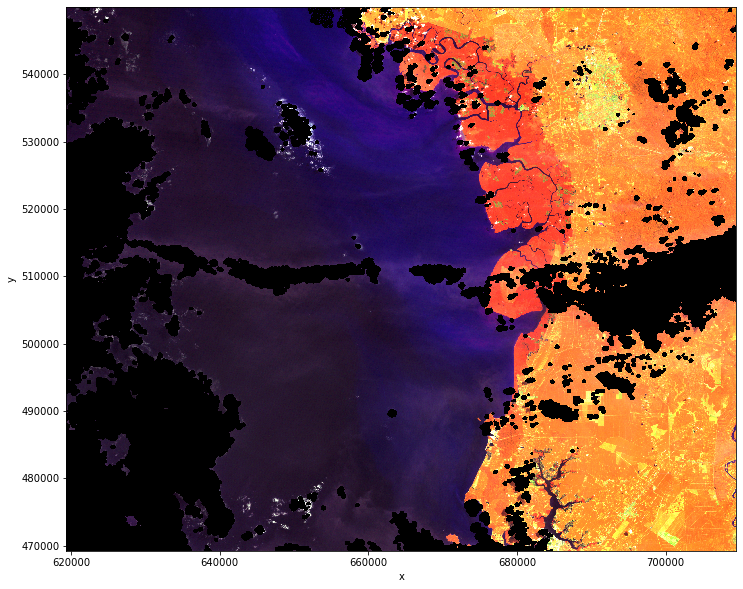

In [4]:
# Create false colour composite with NIR, SWIR1, and Red bands
mfr_2010.sel(band=[3,4,1]).plot.imshow(figsize=(12, 10))

Now that we have an image, we need to load a land cover mask. This serves as our target, or ground truth variable. In this case, the mask is derived from the [Global Mangrove Watch](https://www.globalmangrovewatch.org/), which provides a highly accurate baseline of mangrove extent for 2010. 

The mask has been cropped to the same extent as the Landsat image.

In [5]:
# Load mask
mfr_mask = xr.open_rasterio('../data/practical_1/MFR_mask.tif')

In [6]:
mfr_mask

<xarray.DataArray (band: 1, y: 2690, x: 3003)>
[8078070 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.499e+05 5.499e+05 5.499e+05 ... 4.693e+05 4.693e+05
  * x        (x) float64 6.194e+05 6.194e+05 6.194e+05 ... 7.094e+05 7.094e+05
Attributes:
    transform:      (30.0, 0.0, 619365.0, 0.0, -30.0, 549945.0)
    crs:            +init=epsg:32647
    res:            (30.0, 30.0)
    is_tiled:       0
    nodatavals:     (255.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

Again, we can see above that the mask has a variety of metadata. It has the same spatial resolution as our Landsat image, and is in the same projected coordinate system. There's only one band, with three values. We can list these if we want to:

In [7]:
# List unique map values
np.unique(mfr_mask[0])

array([0, 1, 2], dtype=uint8)

In this case, 2 = Mangroves, 1 = Water, and 0 = Other (non-mangrove) terrestrial land cover. The map can be visualised using the same method as above.

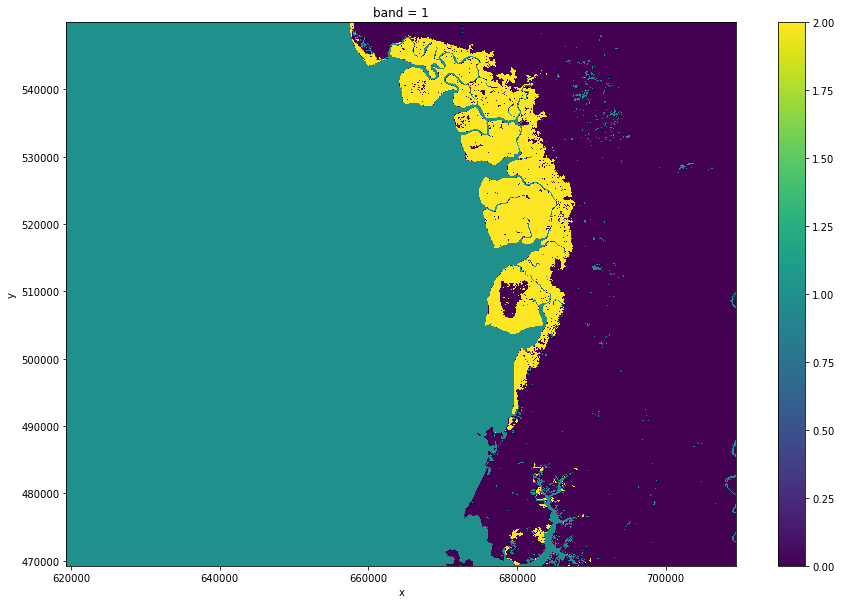

In [8]:
mfr_mask[0].plot.imshow(figsize=(15, 10))

We're going to combine our band values and mask into a single Dataset object. This is to make sure that both remain on the same spatial (x, y) grid while we carry out processing. Also, Xarray Data Arrays work less well for data where we have multiple variables. Datasets are more intuitive for this case. For more information on Xarray data structures, [have a look at the documentation](http://xarray.pydata.org/en/stable/user-guide/data-structures.html).

In [9]:
# Convert to Dataset
mfr_2010 = mfr_2010.to_dataset('band')

In [10]:
# Add the mask as a new variable
mfr_2010['lc_mask'] = mfr_mask[0]

In [11]:
# Have a look at our new dataset
mfr_2010

<xarray.Dataset>
Dimensions:  (y: 2690, x: 3003)
Coordinates:
  * y        (y) float64 5.499e+05 5.499e+05 5.499e+05 ... 4.693e+05 4.693e+05
  * x        (x) float64 6.194e+05 6.194e+05 6.194e+05 ... 7.094e+05 7.094e+05
    band     int64 1
Data variables:
    1        (y, x) uint16 ...
    2        (y, x) uint16 ...
    3        (y, x) uint16 ...
    4        (y, x) uint16 ...
    lc_mask  (y, x) uint8 ...
Attributes:
    transform:      (30.0, 0.0, 619365.0, 0.0, -30.0, 549945.0)
    crs:            +init=epsg:32647
    res:            (30.0, 30.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('Green', 'Red', 'NIR', 'SWIR1')
    AREA_OR_POINT:  Area

We can see the four spectral bands (Green, Red, NIR, SWIR1), and the mask has been added as lc_mask.

Now that we have a combined data set, let's try and do some sampling to generate our training data. This is the set of samples we will use to train our Random Forest, so it needs to contain samples from all of the land cover classes present.

We will first try to take a random sample of our data, by randomly sampling from both the *x* and *y* axes. The following line generates 50 random x values, and 50 random y values, to give a total of 2500 samples

In [12]:
# Randomly sample 2500 points (50*50)
random_sample = mfr_2010.isel(x=np.random.randint(0, mfr_mask.x.size, 50), y=np.random.randint(0, mfr_mask.y.size, 50))

Let's check that the sample list contains the right number of samples.

In [13]:
random_sample.lc_mask.size

2500

So the number of samples is correct - but how about the class distribution?

In [14]:
land_samples = np.count_nonzero(~np.isnan(xr.where(random_sample.lc_mask == 0, 0, np.nan)))
water_samples = np.count_nonzero(~np.isnan(xr.where(random_sample.lc_mask == 1, 1, np.nan)))
mgve_samples = np.count_nonzero(~np.isnan(xr.where(random_sample.lc_mask == 2, 2, np.nan)))

print("Number of non-mangrove land samples: {}".format(land_samples))
print("Number of water samples: {}".format(water_samples))
print("Number of mangrove samples: {}".format(mgve_samples))

Number of non-mangrove land samples: 668
Number of water samples: 1733
Number of mangrove samples: 99


It's clear that thenumber of samples we have per class is not very balanced - it will vary each time, but you're probably seeing about a 7x greater sample size for water than for mangroves. After all, there is a lot more water in the image than mangroves. 

This is problematic because it means our classifier will "see" a lot more water samples than mangrove samples. This could cause it to overestimate the water class when applied to new data, and underestimate the mangrove class. For more details on imbalanced datasets and the problems they cause, have a look at [A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/).

What we need is to take an equal sample for each class. Unfortunately, the Xarray library doesn't yet have the functionality to carry out stratified sampling. So to do this, we're going to convert our xarray Dataset into a Pandas dataframe. This will "flatten" the data so that each row in the dataframe represents a single pixel, putting the image into a tabular rather than a raster format.

In [15]:
mfr_dataframe = mfr_2010.to_dataframe().reset_index()

We can see below that our data is now arranged as a table.

In [16]:
mfr_dataframe

,y,x,1,2,3,4,band,lc_mask
0,549930.0,619380.0,44,34,36,10,1,1
1,549930.0,619410.0,48,34,39,17,1,1
2,549930.0,619440.0,44,34,36,15,1,1
3,549930.0,619470.0,44,37,36,12,1,1
4,549930.0,619500.0,48,34,36,12,1,1
...,...,...,...,...,...,...,...,...
8078065,469260.0,709320.0,51,40,357,160,1,0
8078066,469260.0,709350.0,51,37,383,169,1,0
8078067,469260.0,709380.0,56,34,387,165,1,0
8078068,469260.0,709410.0,57,37,398,175,1,0


We still have the 'band' variable in there, left over from loading our mask. We can drop that column.

In [17]:
mfr_dataframe = mfr_dataframe.drop('band', axis=1)

In [18]:
mfr_dataframe

,y,x,1,2,3,4,lc_mask
0,549930.0,619380.0,44,34,36,10,1
1,549930.0,619410.0,48,34,39,17,1
2,549930.0,619440.0,44,34,36,15,1
3,549930.0,619470.0,44,37,36,12,1
4,549930.0,619500.0,48,34,36,12,1
...,...,...,...,...,...,...,...
8078065,469260.0,709320.0,51,40,357,160,0
8078066,469260.0,709350.0,51,37,383,169,0
8078067,469260.0,709380.0,56,34,387,165,0
8078068,469260.0,709410.0,57,37,398,175,0


We can now use the Pandas *groupby* function to group the data by land cover class, and take an even sample from each class.

In [ ]:
samples_per_class = 500

stratified_sample = mfr_dataframe.groupby('lc_mask', group_keys=False).apply(lambda x: x.sample(samples_per_class))
len(stratified_sample)

Now we have 1500 samples, 500 from each class.

In [ ]:
print(len(stratified_sample[stratified_sample.lc_mask == 0])) # Other terrestrial
print(len(stratified_sample[stratified_sample.lc_mask == 1])) # Water
print(len(stratified_sample[stratified_sample.lc_mask == 2]))# Mangroves

## Training a Random Forest classifier on the CPU

Next we will train a Random Forest classifier on the 1500 samples taken above. To do this, we will utilise the [scikit-learn](https://scikit-learn.org/stable/) library. Scikit-learn is widely used for data analysis in Python and contains a huge range of functions for data pre-processing, classification, clustering, regression, and much more.

In [ ]:
# Import scikit-learn functions
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

When training a machine learning model, we typically do not use all of our samples for training. Instead, we split the samples into a **training set**, a **validation set**, and a **test set**. The training set is used to train the model (of course!). The validation set is used to evaluate the model during hyperparameter tuning. For example, we might train the model once, test it's accuracy on the validation set, then alter a specific model hyperparameter before re-training and re-validating. This allows us to check that the model is improving using independent data. Otherwise, hyperparameter tuning could lead to model overfitting.

The test set is kept completely separate from the training and validation sets, and is not used until we have a finalised model. The test set is then used to evaluate the performance of the final model. If the model has been trained correctly, performance on the useen test data should be similar to performance on the training and validation sets. There's more information on data splitting and why we do it [here](https://www.v7labs.com/blog/train-validation-test-set).

In this case, we're not going to do any hyperparameter tuning (though we will in a later tutorial). So, we're just splitting the data into a training set and a test set. Scikit-learn provides a function for this. In this case, we're using 80% of our data as training data, and 20% as a test set.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(stratified_sample[[1,2,3,4]], stratified_sample['lc_mask'], train_size=0.8, shuffle=True)

Now we can train the classifier.

At this point, we're running the training algorithm on Central Processing Units (CPUs). These are the standard processors computers use to execute instructions. Your own machine probably has four or eight of these. In this notebook we currently have access to 10, so we're going to use all of them.

Notice the **%%time** command in the cell below. This is what's know as a magic command. It will time how long it takes to execute the code in the cell, and print the result.

In [ ]:
%%time
rf_class = RandomForestClassifier(n_jobs=10).fit(x_train, y_train)

That didn't take very long! Let's have a look at our training accuracy. We can do this using the **score** function.

In [ ]:
rf_class.score(x_train, y_train)

What about the test set?

In [ ]:
rf_class.score(x_test, y_test)

You should see a training accuracy of about 90%, and a test accuracy of 85-90%. Test accuracy is typically lower than training accuracy, but the values should be close if the training set is well chosen and approximates the distribution of the underlying data.

## Moving from CPU to GPU with RAPIDS

In the last section, we trained a Random Forest classifier using a random stratified sample of 1500 pixels. However, our whole Landsat image and map contain over 8 million pixels each. What if we want to take a larger sample? **You can try increasing the number of samples by altering the sample_per_class variable above. How much longer does it take to carry out sampling if we increase the sample size to 5000 per class? How much longer does it take to train the classifier?**

[RAPIDS](https://rapids.ai/index.html) is a set of libraries designed to help you move operations from CPU to GPU (Graphics Processing Unit) compute. While CPUs are great for carrying out complex instructions, GPUs have thousands of cores and are excellent for executing many operations in parallel. This is perfect for many machine learning algorithms, which are often embarrasingly parallel in nature.

Once installed, RAPIDS provides drop-in replacements for many common functions from Pandas and scikit-learn. This means that we can easily train our Random Forest classifier on a GPU with a few small changes. We're going to be making use of a library called cuDF instead of Pandas, and a library called cuML in place of scikit-learn.

In [ ]:
import cudf
import cuml

# Notice that these two libraries replace the ones we imported at the start
from cuml.ensemble import RandomForestClassifier
from cuml.preprocessing.model_selection import train_test_split

First, we move our Pandas dataframe into a CUDA dataframe. This transfers the data to GPU memory.

In [ ]:
cudf_data = cudf.DataFrame.from_pandas(mfr_dataframe)

We can actually check how much memory is being utilised on the GPU using the **nvidia-smi** command:

In [ ]:
!nvidia-smi

Even though it's now in GPU memory, we can interact with the dataframe in the same ways as we could before.

In [ ]:
cudf_data

Sampling a cuDF dataframe is the same as sampling a Pandas dataframe. However, this time we're going to take 50,000 samples per class - 100 times more than before.

In [ ]:
samples_per_class = 50000

cudf_sample = cudf_data.groupby('lc_mask').apply(lambda x: x.sample(samples_per_class))
cudf_sample

In [ ]:
# This is 100x as many samples as before
len(cudf_sample)

We can use the same logic to check our per-class sample sizes as we used for Pandas.

In [ ]:
print(len(cudf_sample[cudf_sample.lc_mask == 0])) # Other terrestrial
print(len(cudf_sample[cudf_sample.lc_mask == 1])) # Water
print(len(cudf_sample[cudf_sample.lc_mask == 2]))# Mangroves

RAPIDS expects our data to be 32-bit floats. We can **cast** the data to change the format ready for processing.

In [ ]:
cudf_sample = cudf_sample.astype('float32')

As before, we split the data into training and test sets.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cudf_sample[[1,2,3,4]], cudf_sample['lc_mask'], train_size=0.75, shuffle=True)

Now let's train our GPU-based model.

In [ ]:
%%time
cuml_rf_class = RandomForestClassifier().fit(x_train, y_train)

How long did training the model take? It will vary each time you run it, but should be around 2-4 seconds. That's around a 4x increase in time with a 100x increase in data!

You can try training the CPU-based model on the same number of samples, by altering the **samples_per_class** value.

Let's check the training and test accuracy of our new model.

In [ ]:
cuml_rf_class.score(x_train, y_train)

In [ ]:
cuml_rf_class.score(x_test, y_test)

You will probably see a lower accuracy for both data sets than we achieved with the CPU-based model. You might also notice that the two accuracy values are much closer together. Why do you think this might be?

**Try changing the number of samples to see how that effects the accuracy of the model on both the training and test sets.**

We now have a trained classifier thar gives reasonable performance on our data. It would be useful to know where our classifier is making mistakes. One way to do this is using a confusion matrix. Scikit-learn has some handy functions we can use for this.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

The **predict** function of our model can be used to generate predicted values for our test pixels.

In [ ]:
# Get predicted y values
y_pred = cuml_rf_class.predict(x_test)

Unfortunately, scikit-learn will not work with cuDF data sets, so we have to convert our actual and predicted values (for the test set) back into Pandas dataframes.

RAPIDS is still very much a work in progress, with new functionality constantly being added. For now it's likely you will have to switch back and forth between Pandas/scikit-learn and cuDF/cuML occasionally during your work.

In [ ]:
y_test = y_test.to_pandas()
y_pred = y_pred.to_pandas()

Making the confusion matrix itself is now easy. Plotting the matrix allows us to visually interpret the results. On the x axis we have the predicted label as generated by the model. On the x axis is the true land cover class derived from the Global Mangrove Watch.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Looking at the confusion matrix, we can more easily see the areas where our labels and predictions disagree. Remember, 0 = Other Terrestrial, 1 = Water, and 2 = Mangroves. We can see that there is some confusion between mangroves water, and also confusion between some other terrestrial land cover and water.

It would be useful to identify where these mistakes are being made. To do that, we can take our classifier and apply it to the original image, to generate a predicted class map.

In [ ]:
%%time
y_pred = cuml_rf_class.predict(cudf_data[[1, 2, 3, 4]])

In [ ]:
y_pred

We can add the predicted values to our existing dataframe as a new column.

In [ ]:
mfr_dataframe['predicted'] = y_pred.to_pandas()
mfr_dataframe

And we can convert this back into an xarrary data set.

In [ ]:
predicted_ds = xr.Dataset.from_dataframe(mfr_dataframe.set_index(['y', 'x']))
predicted_ds

Let's plot our predicted and actual land cover maps.

In [ ]:
# Plot actual land cover mask
predicted_ds.lc_mask.plot.imshow(figsize=(15, 10))

In [ ]:
# Plot predicted land cover mask
predicted_ds.predicted.plot.imshow(figsize=(15, 10))

We can see an interesting problem with our predicted class map. Let's have another look at the Landsat image we're using as input.

In [ ]:
predicted_ds[[3, 4, 1]].to_array().plot.imshow(figsize=(12, 10))

We can see that many of the miss-classified areas are actually areas of cloud. These pixels have a value of 0 on our input map, and since most of the missing data is over the ocean, they get classified as water.

There are several methods we could use to deal with this problem.

1. Fill the gaps in the original image, for example, by finding another image without missing data in these areas. This is called **compositing**, and is frequently used for areas with high cloud cover where getting a single image without cloud is nearly impossible.

1. Remove these pixels from processing, since we know they contain no data, and add them back in afterwards.

1. Create a new class specifically to deal with clouds.

In this tutorial we're going to cover options 2 and 3, both of which are relatively straightforward.

For Option 2, we first need to separate out all of the pixels with a value of 0 in all bands. We can easily do this using our dataframe and some Boolean logic. This is being executed on the GPU with our cuDF dataframe.

In [ ]:
# Create a dataframe containing only non-cloud pixels (pixels with a value greater than 0)
cudf_no_clouds = cudf_data[(cudf_data[1] > 0) & (cudf_data[2] > 0) & (cudf_data[3] > 0) & (cudf_data[4] > 0)]

In [ ]:
# Create a dataframe containing cloud pixels (pixels with a value of 0 for all bands)
cudf_just_clouds = cudf_data[(cudf_data[1] == 0) & (cudf_data[2] == 0) & (cudf_data[3] == 0) & (cudf_data[4] == 0)]

In [ ]:
len(cudf_data)

In [ ]:
# These two added together should equal the length of the full dataframe
len(cudf_no_clouds) + len(cudf_just_clouds)

We can't use the same classifier on before, becuase that classifier was trained on our dataset with clouds. So, we need to train a new classifier on our cloud-free dataset.

In [ ]:
no_cloud_sample = cudf_no_clouds.groupby('lc_mask').apply(lambda x: x.sample(50000))
no_cloud_sample = no_cloud_sample.astype('float32')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(no_cloud_sample[[1,2,3,4]], no_cloud_sample['lc_mask'], train_size=0.8, shuffle=True)

In [ ]:
cuml_rf_class = RandomForestClassifier().fit(x_train, y_train)

In [ ]:
# Check accuracy again
cuml_rf_class.score(x_train, y_train)

In [ ]:
cuml_rf_class.score(x_test, y_test)

If everything has gone well, you should now see accuracies of 95%+ for the training and test sets. Removing the cloud removed most of the error!

We can use our model to predict the land cover classes for all of our cloud-free pixels.

In [ ]:
pred_just_clouds = cuml_rf_class.predict(cudf_no_clouds[[1, 2, 3, 4]])

In [ ]:
# Add a predicted column onto our no-clouds dataframe
cudf_no_clouds['predicted'] = y_pred

# Convert the cuDF dataframe back to a Pandas dataframe
df_no_clouds = cudf_no_clouds.to_pandas()

We can add a predicted column onto our cloud-only dataframe as well for consistency. Since 0 is already taken (other terrestrial), let's give cloud pixels a value of 3.

In [ ]:
cudf_just_clouds['predicted'] = 3

Convert the cloud-only dataframe back into Pandas as well.

In [ ]:
df_clouds = cudf_just_clouds.to_pandas()

Now we can re-combine the two datasets so that we have one Pandas dataframe with all of the pixel values.

In [ ]:
# Now combine them
combined_df = pd.concat([df_no_clouds, df_clouds])

In [ ]:
# Convert back to xarray
predicted_sep_clouds = xr.Dataset.from_dataframe(combined_df.set_index(['y', 'x']))

In [ ]:
# Plot the new land cover predictions
predicted_sep_clouds.predicted.plot.imshow(figsize=(15, 10))

The above map looks a bit different because the scale has changed, but we can see that the classifier has worked pretty well on our no-cloud areas, and clouds are now shown in yellow.

**Can you think of any disadvantages of this method? How about if we want to apply our classifier to a different image?** (We're actually going to do this in a minute).

Option 3 was to create a new class specifically for clouds. The advantage of this is that we don't need to remove our masked-out cloud areas from images before running the classifier. This approach is also quite straightforward; we can replace the map values for the areas covered by cloud with a different value specifically for clouds. 

We can re-use our sample from earlier. Random Forest needs labels to be consecutive from 0 to the number of unique values, so let's add cloud as an extra class with a value of 3.

In [ ]:
# This looks quite complicated, but it's just setting the lc_mask column to 0 if all the other columns equal 0
cudf_sample['lc_mask'][(cudf_sample[1] == 0) & (cudf_sample[2] == 0) & (cudf_sample[3] == 0) & (cudf_sample[4] == 0)] = 3

Next we create the training and test sets again, and train the classifier.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cudf_sample[[1,2,3,4]], cudf_sample['lc_mask'], train_size=0.8, shuffle=True)

In [ ]:
cuml_rf_class = RandomForestClassifier().fit(x_train, y_train)

Check the accuracy:

In [ ]:
# Check training accuracy
cuml_rf_class.score(x_train, y_train)

In [ ]:
# Check test accuracy
cuml_rf_class.score(x_test, y_test)

Accuracy should be about as high as when we excluded the cloud from training - and much higher than when our dataset ignored the cloud-covered pixels.

Again, we can generate predictions, convert back to Xarray, and plot the results. The map below should look very similar to the one above, where we excluded the cloud covered pixels before training.

In [ ]:
y_pred = cuml_rf_class.predict(cudf_data[[1, 2, 3, 4]])

mfr_dataframe['predicted'] = y_pred.to_pandas()

predicted_with_cloud_class = xr.Dataset.from_dataframe(mfr_dataframe.set_index(['y', 'x']))

predicted_with_cloud_class.predicted.plot.imshow()

The above class map shows cloud in yellow. Since this class is very easy to identify, the cloud pixels above should match nearly exactly the original cloud mask.

## Prediction for new data

So far we've been training and testing on the same image. It would be interesting to generate a class map for a new image using our classifier. We're going to try classifying two Landsat 8 images - one of the Matang Forest Reserve from 2015, and one of the Niger Delta from 2013.

The following cell contains a function that will load an image, place it onto the GPU, generate the model predictions, convert the predicted values back to Pandas/Xarray, and plot the result. Having functions like this allows us to easily re-use the same code on multiple input images

In [ ]:
def generate_class_map(input_data_array):
    
    ds = input_data_array.to_dataset('band')
    
    dataframe = ds.to_dataframe().reset_index()
    
    cudf_data = cudf.DataFrame.from_pandas(dataframe)
    
    predicted_class = cuml_rf_class.predict(cudf_data[[1, 2, 3, 4]])
    
    dataframe['predicted'] = predicted_class.to_pandas()
    
    ds_with_predictions = xr.Dataset.from_dataframe(dataframe.set_index(['y', 'x']))
    
    return(ds_with_predictions)

After loading the function, we use Xarray again to open the two new images.

In [ ]:
mfr_2015 = xr.open_rasterio('../data/practical_1/MFR_LS8_2015.tif')
nigeria_2013 = xr.open_rasterio('../data/practical_1/ND_LS8_2013.tif')

Now we fetch the predictions...

In [ ]:
mfr_predicted = generate_class_map(mfr_2015)
nigeria_predicted = generate_class_map(nigeria_2013)

...and plot them.

In [ ]:
mfr_predicted.predicted.plot.imshow(figsize=(15, 10))

In [ ]:
nigeria_predicted.predicted.plot.imshow(figsize=(20, 10))

The classifier has performed reasonably, but in both maps there are some pixels further inland that have been classified as mangroves when they clearly aren't. The map for the Niger Delta also includes some small water bodies as mangroves.

**Why might this problem occur? How could we mitigate it?**

## Saving and loading with RAPIDS 

You can also save CSV files directly from GPU memory with cuDF:

In [ ]:
cudf_data.to_csv('pixel_data.csv', index=False)

An to load them directly into GPU memory:

In [ ]:
loaded_dataset = cudf.read_csv('pixel_data.csv', index=False)
loaded_dataset.head()

In the next notebook, we will look at a completely different problem: Regression.